## 背景
我们知道，我国的汽车牌照由各省的简称 + 24 个英文字母（由于字母不包括I和O）+ 0~9 自由组合而成，因此，训练出能识别这些汉字，字母和数字的深度学习模型成为可能。而汽车牌照识别的原理，这里主要分为三大步：
1. 图像处理
2. 深度学习字符识别模型
3. 文字转语音

## 一、图像处理
主要使用 OpenCV 进行图像的处理工作，包括图像的模糊，形态学处理，车牌图像的提取以及字符图片的分割。



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1、读取图像

(-0.5, 442.5, 312.5, -0.5)

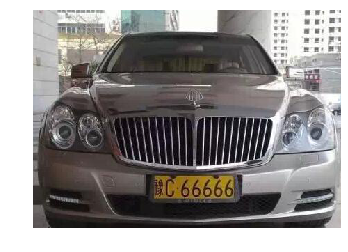

In [2]:
img_file = "../dataset/test/7.jpg"
img = cv2.imread(img_file)
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # cv2默认是以BGR的格式进行图片的读取的
plt.imshow(img_show)
plt.axis("off")

### 2、图像降噪
使用高斯模糊对图像进行降噪

(-0.5, 442.5, 312.5, -0.5)

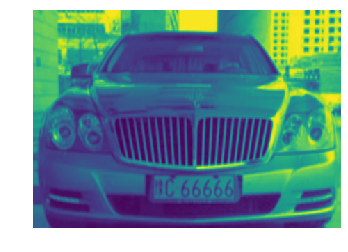

In [3]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gauss_img = cv2.GaussianBlur(gray_img, (5, 5), 0, 0, cv2.BORDER_DEFAULT)
plt.imshow(gauss_img)
plt.axis("off")

### 3、定位车牌位置
1. 先使用较大的 kernel 对图片执行开运算（先腐蚀，后膨胀），使得车牌区域变成连通的一片。

(-0.5, 442.5, 312.5, -0.5)

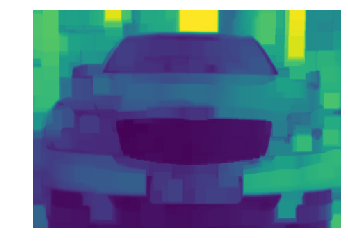

In [4]:
kernal = np.ones((20, 20), np.uint8)
img_opening = cv2.morphologyEx(gauss_img, cv2.MORPH_OPEN, kernal)
plt.imshow(img_opening)
plt.axis("off")

2. 执行顶帽运算（原图像 - 开运算图像），可以突出原图像中比周围亮的区域

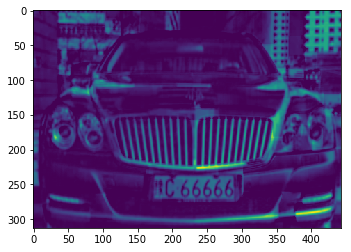

In [5]:
img_top_hat = cv2.addWeighted(gauss_img, 1, img_opening, -1, 0)
plt.imshow(img_top_hat)

3. 找到图像的边缘

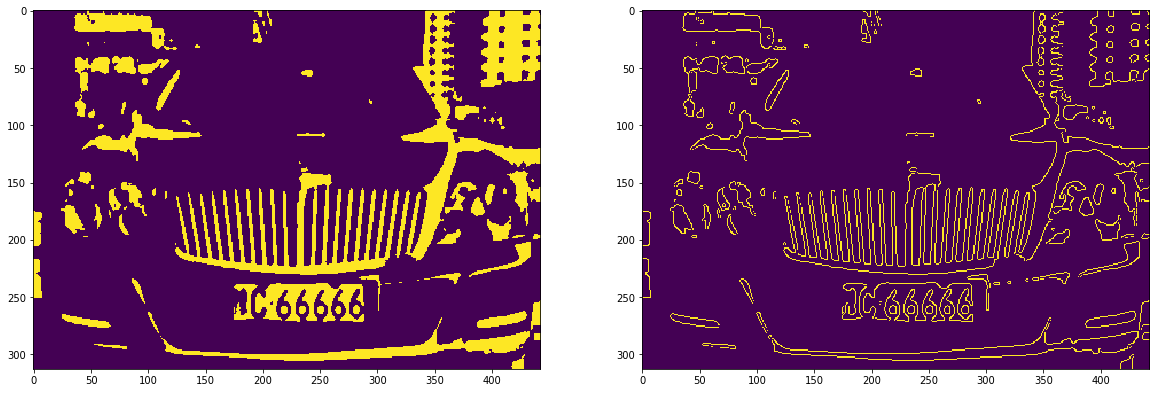

In [6]:
ret, img_thresh = cv2.threshold(img_top_hat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img_edge = cv2.Canny(img_thresh, 100, 200)
fig, axes = plt.subplots(1, 2, figsize = (20, 16))
axes[0].imshow(img_thresh)
axes[1].imshow(img_edge)

4. 使用闭运算和开运算使边缘成为一个整体  
闭运算（先膨胀后腐蚀），使得临近的亮像素点连成一片。执行完闭运算之后再执行开运算，可以消除图片中非成片的亮点。

Text(0.5, 1.0, 'edge image with morph open')

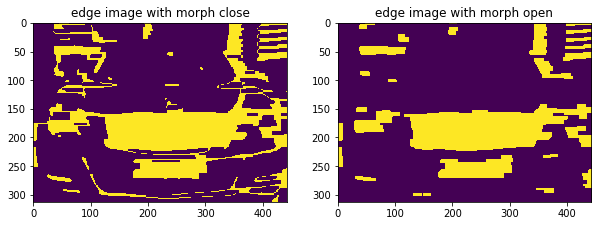

In [7]:
kernel1 = np.ones((4, 19), np.uint8)
img_edge_close = cv2.morphologyEx(img_edge, cv2.MORPH_CLOSE, kernel1)
kernel2 = np.ones((5, 12), np.uint8)
img_edge_open = cv2.morphologyEx(img_edge_close, cv2.MORPH_OPEN, kernel2)
fig, axes = plt.subplots(1, 2, figsize = (10, 8))
axes[0].imshow(img_edge_close)
axes[0].set_title("edge image with morph close")
axes[1].imshow(img_edge_open)
axes[1].set_title("edge image with morph open")

5. 查找图像边缘整体形成的矩形区域，在图片中可能有很多个矩形区域，车牌的区域就是其中的一个。为了得到正确的车牌区域，需要设计一系列筛选的规则对找到的边缘进行筛选。  
a. 车牌区域的面积在一个合适的范围内  
b. 车牌区域的长宽比在一个合适的范围内  
c. 车牌的颜色（目前只识别蓝、黄、绿的车牌）

In [8]:
# 使用车牌区域的面积进行筛选
min_area = 500
max_area = 2000
img_contour, contours, hierarchy = cv2.findContours(img_edge_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
print("number of contours selected: ", len(contours))

number of contours selected:  7


In [9]:
# 使用车牌区域的长宽比进行筛选
min_ratio = 2
max_ratio = 5.5
plate_contours = []
for cnt in contours:
    """
    cv2.minAreaRect()的返回值为：((center.x, center.y), (width, height), angle),
    其中 angle 的范围为 -90 ~ 0 °,angle 的计算方法是水平轴 x 逆时针旋转，与矩形
    第一条边相遇时转过的角度
    """
    rect = cv2.minAreaRect(cnt)       # 找到包围每个边缘点集的最小矩形
    area_width, area_height = rect[1]
    if area_width < area_height:      # 保证较长的边为宽
        area_width, area_height = area_height, area_width
    wh_ratio = area_width / area_height
    if wh_ratio > min_ratio and wh_ratio < max_ratio:
        plate_contours.append(rect)   # 保存可能为车牌区域的最小外接矩形
print("number of contours selected: ", len(plate_contours))

number of contours selected:  5


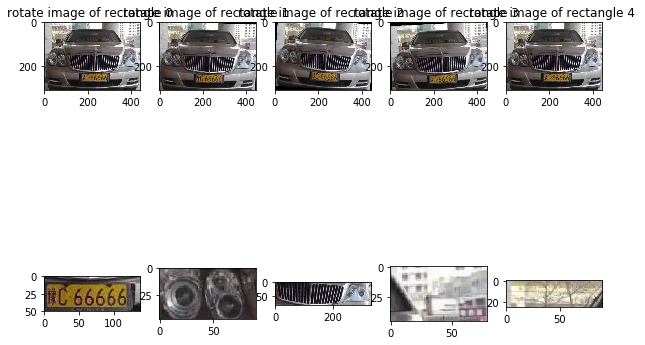

In [10]:
# 将上面找到的最小外接矩形所包含的图片区域提取出来，以便进行下一步的筛选
# 因为最小外接矩形是有角度的，不一定是平行的矩形，所以先要将图片进行旋转，使最小外接矩形平行
plate_rois = []
h, w = img.shape[:2]
fig, axes = plt.subplots(2, len(plate_contours), figsize = (10, 8))
index = 0
for rect in plate_contours:
    angle = rect[2]
    
    # 旋转调整时的角度 angle 是由经验值确定的，我们假设汽车在图片中不会倾斜45°以上
    if abs(angle) < 45:
        angle = angle
    elif abs(angle) > 45:
        angle = 90 - abs(angle)

    # 需要注意的是当使用 getRotationMatrix2D()进行旋转的时候，逆时针旋转角度为正，顺时针为负
    # 而 rect 中的 angle，逆时针为负
    rotate_matrix = cv2.getRotationMatrix2D(rect[0], angle, scale = 1)
    rotate_img = cv2.warpAffine(img, rotate_matrix, img.shape[1::-1])    # 将原始图片进行旋转
    axes[0][index].imshow(cv2.cvtColor(rotate_img, cv2.COLOR_BGR2RGB))      # 绘制旋转调整之后的图像
    axes[0][index].set_title("rotate image of rectangle %d "%(index))
    
    center_y = rect[0][1]
    center_x = rect[0][0]
    width = rect[1][0]
    height = rect[1][1]
    
    if angle > 0:
        width, height = height, width
    # 在取 ROI 时要多取一点，防止没有取全
    if width > height:
        plate_roi = rotate_img[max(0, int(center_y - height/2)-5): min(h, int(center_y + height/2)+5), 
                               max(0, int(center_x - width/2)-5): min(w, int(center_x + width/2)+5), 
                           :]
        plate_rois.append(plate_roi)
    axes[1][index].imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
    index += 1


number of plate images:  1
color of plate:  yellow


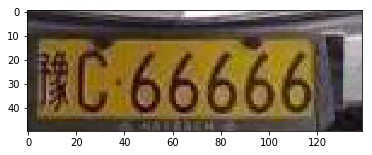

In [11]:
"""
使用颜色对车牌区域进行识别
使用HSV模型来表示图片，H表示图片的色调，S表示饱和度，V表示亮度
H 对应的范围：
Orange  0-22
Yellow 11- 34
Green 34-99
Blue 99-124
Violet 130-160
Red 160-179
S 越大，表示颜色的纯度越高，这里取 S>50
"""
plate_img = []
for plate_roi in plate_rois:
    hsv_plate = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2HSV)
    height, width, channels = hsv_plate.shape[:]
    h_plate = hsv_plate[:, :, 0]
    s_plate = hsv_plate[:, :, 1]
    yellow = 0
    green = 0
    blue = 0
    color_thresh = width * height / 2
    for row in range(height):
        for col in range(width):
            if 34 > h_plate[row][col] > 11 and s_plate[row][col] > 50:
                yellow += 1
            elif 99 > h_plate[row][col] > 34 and s_plate[row][col] > 50:
                green += 1
            elif 124 > h_plate[row][col] > 99 and s_plate[row][col] > 50:
                blue += 1
    if yellow > color_thresh and yellow > max(green, blue):
        plate_img.append([plate_roi, 'yellow'])
    elif green > color_thresh * 0.5 and green > max(yellow, blue):
        plate_img.append([plate_roi, 'green'])
    elif blue > color_thresh and blue > max(yellow, green):
        plate_img.append([plate_roi, 'blue'])
    
#     _yellow = np.where(np.where(h_plate > 22, h_plate, 0) < 38, 1, 0).sum()
#     _green = np.where(np.where(h_plate > 38, h_plate, 0) < 75, 1, 0).sum()
#     _blue = np.where(np.where(h_plate > 75, h_plate, 0) < 130, 1, 0).sum()
#     if max(_yellow, _green, _blue) > width * height / 4:
#         print(max(_yellow, _green, _blue), width * height)
#         plate_img

print("number of plate images: ", len(plate_img))
for plate in plate_img:
    print("color of plate: ", plate[1])
    plt.imshow(cv2.cvtColor(plate[0], cv2.COLOR_BGR2RGB))

5. 通过上述步骤已经找出了车牌的大致位置，接下来需要对车牌位置进行微调。  
通过观察上述图片，可以得出以下结论：车牌颜色出现波峰的位置，就是车牌的精确位置

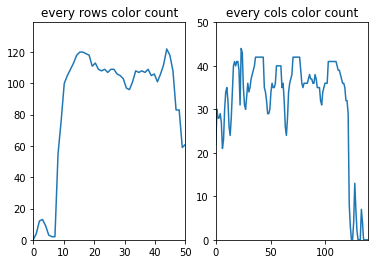

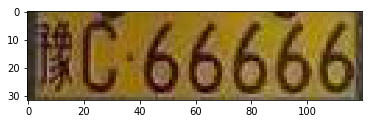

In [20]:
def accurate_location(plate_img, row_num_min, col_num_min):
    """
    通过统计 H 通道中横向和纵向车牌颜色对应的值出现的次数，来判断是否为精确的车牌区域。
    Args:
        plate_img: list类型，通过上一步颜色筛选得到的结果 [[bgr图片，"颜色"], ...]
        row_num_min: 判定某一行为车牌区域的最小比例（颜色值在范围内的元素占行元素总数的比例）
        col_num_min: 判定某一列为车牌区域的最小比例（颜色值在范围内的元素占列元素总数的比例）
    """
    
    acc_plate_imgs = []
    for plate in plate_img:
        hsv_plate = cv2.cvtColor(plate[0], cv2.COLOR_BGR2HSV)
        h_plate = hsv_plate[:, :, 0]
        s_plate = hsv_plate[:, :, 1]
        v_plate = hsv_plate[:, :, 2]
        rows, cols = h_plate.shape[:]
        color = plate[1]
        limit1 = 0
        limit2 = 0
        if 'yellow' == color:
            limit1 = 11
            limit2 = 34
        elif 'green' == color:
            limit1 = 34
            limit2 = 99
        elif 'blue' == color:
            limit1 = 99
            limit2 = 124
        else:
            continue
        
        row_hist = []
        col_hist = []
        for row in range(rows):
            count = ((h_plate[row] > limit1) & (h_plate[row] < limit2)).sum()
            row_hist.append(count)
            
        for col in range(cols):
            count = ((h_plate[:, col] > limit1) & (h_plate[:, col] < limit2)).sum()
            col_hist.append(count)
        
        """
        显示颜色值位于区域内的元素个数的分布情况
        """
        fig, axes = plt.subplots(1, 2)
        axes[0].plot(np.linspace(0, rows, rows), row_hist)
        axes[1].plot(np.linspace(0, cols, cols), col_hist)
        axes[0].set_xlim(0, rows)
        axes[0].set_ylim(0, cols)
        axes[0].set_title("every rows color count")
        axes[1].set_xlim(0, cols)
        axes[1].set_ylim(0, rows)
        axes[1].set_title("every cols color count")
        
        """
        设置阈值对车牌区域进行微调
        """
        row_begin = 0
        row_end = 0
        for index, row_count in enumerate(row_hist):
            if row_count > row_num_min * cols and s_plate[index].mean() > 40:
                row_begin = index
                for index, row_count in enumerate(row_hist[::-1]):
                    if row_count > row_num_min * cols and s_plate[index].mean() > 40:
                        row_end = rows - index
                        break
                break
        
        col_begin = 0
        col_end = 0
        for index, col_count in enumerate(col_hist):
            if col_count > col_num_min * rows and s_plate[:, index].mean() > 40:
                col_begin = index
                for index, col_count in enumerate(col_hist[::-1]):
                    if col_count > col_num_min * rows and s_plate[:, index].mean() > 40:
                        col_end = cols - index
                        break
                break
#         plt.imshow(plate[0][row_begin: row_end, col_begin: col_end, :])
        acc_plate_imgs.append([plate[0][row_begin: row_end, col_begin: col_end, :], color])
    return acc_plate_imgs
        
acc_plate_imgs = accurate_location(plate_img, 0.8, 0.5)
fig = plt.figure()
plt.imshow(cv2.cvtColor(acc_plate_imgs[0][0], cv2.COLOR_BGR2RGB))

### 4、在找到车牌的精确位置之后，需要对车牌中的字符进行分割


consensus score: 1.0


Text(0.5, 1.05, 'Checkerboard structure of rearranged data')

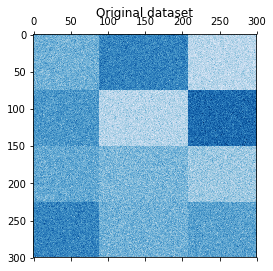

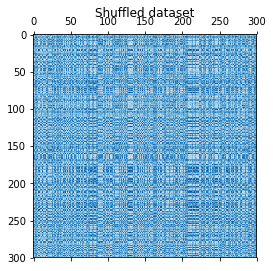

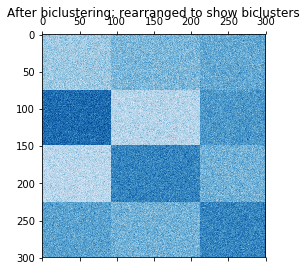

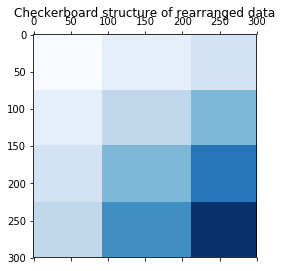

In [21]:
import numpy as np
from matplotlib import pyplot as plt
 
from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score
 
n_clusters = (4, 3)
data, rows, columns = make_checkerboard(
    shape=(300, 300), n_clusters=n_clusters, noise=10,
    shuffle=False, random_state=0)
 
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")
 
data, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")
 
model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))
 
print("consensus score: {:.1f}".format(score))
 
fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
 
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
 
plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")
